## To Address Analysis

Find out top 2000 `to` addresses.

In [1]:
import gzip
import json
from json.decoder import JSONDecodeError
import lzma
import pandas as pd
from typing import Any, Dict, List, Set, Tuple

In [2]:
pd.io.json._json.loads = lambda s, *a, **kw: json.loads(s)

## Filter out useless data

Transactions sent to tokens, pairs, routers and verified contracts are useless, we don't care about them.

In [3]:
def read_whitelist() -> Set[str]:
    result = set()
    with lzma.open('./data/bep20_tokens.json.xz', "rt") as f_in:
        txt = f_in.read()
        arr = json.loads(txt)
        result.update(arr)
    with lzma.open('./data/contracts_verified.json.xz', "rt") as f_in:
        txt = f_in.read()
        arr = json.loads(txt)
        result.update(arr)

    result.add('0x55d398326f99059ff775485246999027b3197955') # BNB
    result.add('0xe9e7cea3dedca5984780bafc599bd69add087d56') # BUSD
    result.add('0x10ed43c718714eb63d5aa57b78b54704e256024e') # pancakeswap
    result.add('0x18b2a687610328590bc8f2e5fedde3b582a49cda') # PancakeSwap: Prediction V2
    result.add('0x1b6c9c20693afde803b27f8782156c0f892abc2d') # FstswapRouter02
    result.add('0x093c639e4291fbdcc339557accdaff52aaac37d9') # Fstswap Farm, see https://mobile.twitter.com/FstSwapbright/status/1519946172911079424
    result.add('0x260e69ab6665b9ef67b60674e265b5d21c88cb45') # SecondLiveFactoryProxy
    result.add('0x3a6d8ca21d1cf76f653a67577fa0d27453350dd8') # BiswapRouter02
    result.add('0xffe811714ab35360b67ee195ace7c10d93f89d8c') # DRIP Faucet Proxy Contract, see https://cryptozoa.com/drip-how-to-have-fun-with-the-faucet-contract-89040160a3b6
    result.add('0xe2d26507981a4daaaa8040bae1846c14e0fb56bf') # Baked Beans
    return result

In [4]:
def filtered_ratio(file: str) -> Tuple[int, int]:
    whitelist = set(read_whitelist())
    
    total_count = 0
    remaining = 0

    # to -> count
    counter: Dict[str, int] = {}
    f_in = None
    if file.endswith('.json'):
        f_in = open(file, "rt")
    elif file.endswith('.json.gz'):
        f_in = gzip.open(file, "rt")
    elif file.endswith('.json.xz'):
        f_in = lzma.open(file, "rt")
    else:
        raise ValueError(file)
    with f_in:
        for line in f_in:
            try:
                obj = json.loads(line)
                to = obj["txContents"]['to']
                total_count += 1
                if to not in whitelist:
                    remaining += 1
            except JSONDecodeError as ex:
                pass # ignore malformed lines
    
    return (total_count, remaining)

In [5]:
%%time
filtered_ratio("./data/bloxroute-tx-gateway-virginia.json.xz")

CPU times: user 36.2 s, sys: 278 ms, total: 36.5 s
Wall time: 36.5 s


(2010561, 1372622)

There are 2010561 lines, and 1372622 lines are not in the white list.

## Histogram of `to`

In [6]:
def read_to_count(file: str) -> Dict[str, int]:
    whitelist = set(read_whitelist())

    # to -> count
    counter: Dict[str, int] = {}
    f_in = None
    if file.endswith('.json'):
        f_in = open(file, "rt")
    elif file.endswith('.json.gz'):
        f_in = gzip.open(file, "rt")
    elif file.endswith('.json.xz'):
        f_in = lzma.open(file, "rt")
    else:
        raise ValueError(file)
    with f_in:
        for line in f_in:
            try:
                obj = json.loads(line)
                to = obj["txContents"]['to']
                if to not in whitelist:
                    if to in counter:
                        counter[to] += 1
                    else:
                        counter[to] = 1
            except JSONDecodeError as ex:
                pass # ignore malformed lines
    
    return counter

In [7]:
%%time
to_counter = read_to_count("./data/bloxroute-tx-gateway-virginia.json.xz")

CPU times: user 36.9 s, sys: 336 ms, total: 37.2 s
Wall time: 37.2 s


In [8]:
to_count_df = pd.DataFrame(to_counter.items(), columns=['to', 'count']).sort_values(by='count', ascending=False, ignore_index=True)

In [9]:
to_count_df

,to,count
0,0xea046790029536f455042409a4c5f6d26f909cc1,33725
1,0x7000e50991946e78a7acae6016d87a38624bb8ab,32646
2,0x82610aa8eb74398420ebfc1254008e51ca32a746,22381
3,0xca4533591f5e5256f1bdb0f07fee3be76a1aae35,15606
4,0xfe702057bdd6e725d8372708d16143f6928b1383,14615
...,...,...
153560,0xba52c1006ea2a8ec1907063b9031a04d08662a21,1
153561,0x41490a43bab16bd701d11cd4ddaac103b6ecc74c,1
153562,0xb88c74f7071c37e18008adf8fdf1c06f12b64eb4,1
153563,0x2c6910a27041d2099b0f98f36b78845f848eef06,1


<AxesSubplot:>

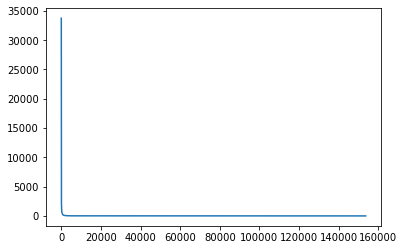

In [10]:
to_count_df['count'].plot()

<AxesSubplot:>

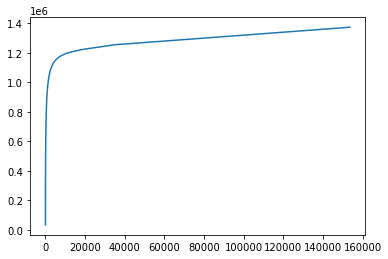

In [18]:
to_count_df['count'].cumsum().plot()

In [19]:
to_count_df['count'].describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    153565.000000
mean          8.938378
std         197.942873
min           1.000000
10%           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
90%           3.000000
95%           8.000000
99%          93.000000
max       33725.000000
Name: count, dtype: float64

In [20]:
filtered_df = to_count_df[to_count_df['count']>8]

In [21]:
filtered_df

,to,count
0,0xea046790029536f455042409a4c5f6d26f909cc1,33725
1,0x7000e50991946e78a7acae6016d87a38624bb8ab,32646
2,0x82610aa8eb74398420ebfc1254008e51ca32a746,22381
3,0xca4533591f5e5256f1bdb0f07fee3be76a1aae35,15606
4,0xfe702057bdd6e725d8372708d16143f6928b1383,14615
...,...,...
7359,0xf3278fa54b730723bd898c21dfd41b9cb89cb1b4,9
7360,0x088bebef4e371757509e64d3508b6da6f376e2ac,9
7361,0x11d20864cfe0e8fed15c10658c298572792dad65,9
7362,0x3b76374cc2dfe28cc373dca6d5024791b2586335,9


<AxesSubplot:>

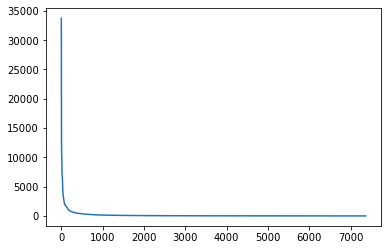

In [22]:
filtered_df['count'].plot()

<AxesSubplot:>

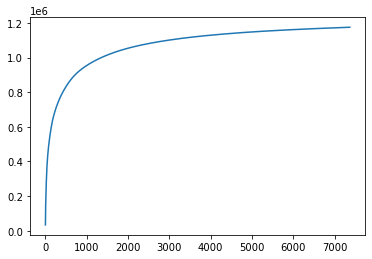

In [23]:
filtered_df['count'].cumsum().plot()

**Conclusion**: The first 1000 `to` addresses send most transactions, while the remaining addresses are retail users, who send very few transactions.